# Add Folders to Path

In [1]:
%%time
import sys, os
# get current directory
path = os.getcwd()
# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-2])
# add Algorithm folder to current working path in order to access the functions inside the folder ´Algorithms´
sys.path.append(parent_directory+"/Src")

Wall time: 0 ns


# Agulhas Region

## Import Data

We start by import the AVISO-data from the file 'Agulhas_AVISO.mat' stored in the folder 'Data'. We highlight, that the algorithm is general enough to capture also geographic areas close to the coastline or islands. In such regions the velocity field is no longer well defined and the velocity field must be extrapolated to capture coastline effects. We do so by imposing a free-slip boundary.

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../Data/Agulhas_AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time = mat_file['t']

Wall time: 106 ms


## Data/Parameters for Dynamical System

In [3]:
import numpy as np

# Number of cores to be used for parallel computing
Ncores = 4

# Periodic boundary conditions
periodic_x = False
periodic_y = False
Periodic = [periodic_x, periodic_y]

## Compute Meshgrid
X, Y = np.meshgrid(x, y)

# List of parameters of the flow.
params_data = {"X": X, "Y": Y, "Time": time, "U": U, "V": V, "Ncores": Ncores, "Periodic": Periodic}

<a id='Spatio-Temporal-Domain-of-Dynamical-System'></a>
## Spatio-Temporal Domain of Dynamical System

In [4]:
%%time

# time
t = 20

# time as array
time = np.array([t])

# longitudinal and latitudinal boundaries (in degrees)
xmin = 0
xmax = 5
ymin = -35
ymax = -30

# spacing of meshgrid (in degrees)
dx = 0.025
dy = 0.025

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

params_DS = {"time": time, "X_domain": X_domain, "Y_domain": Y_domain}

# Initialize Dynamical System
from ipynb.fs.defs.DynamicalSystem import *

DS = Dynamical_System(params_data, params_DS)

Wall time: 291 ms


## Velocity Interpolation

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". In order to favour a smooth velocity field, we interpolate the velocity field in space using a cubic interpolant. 

In [5]:
%%time
# Interpolate velocity data using cubic spatial interpolation
DS._Interpolation_velocity("cubic")

Wall time: 76.1 ms


## Instantaneous Vorticity Deviation (IVD)

Next, we compute the Instantaneous Vorticity Deviation (IVD) for the initial conditions defined on the meshgrid ('X_domain', 'Y_domain') at time 't'. This involves calculating the spin tensor (and thereby also the gradient of the velocity field) using an auxiliary grid. 'aux_grid' specifies the ratio between the auxiliary grid and the original meshgrid. This parameter is generally chosen to be between $ [\dfrac{1}{20}, \dfrac{1}{100}] $.

In [6]:
%%time
# Import function to calcualte IVD
from ipynb.fs.defs.IVD import _IVD

# Define ratio of auxiliary grid vs original meshgrid
aux_grid = 0.05

IVD = _IVD(X_domain, Y_domain, DS, time[0], aux_grid)

  0%|          | 0/201 [00:00<?, ?it/s]

Wall time: 11.7 s


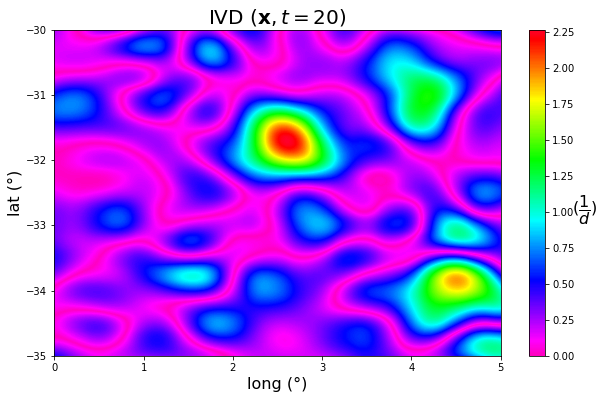

In [14]:
######################## PLOT IVD ########################
import matplotlib.pyplot as plt

# Figure/Axes
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()

# Contourplot of TSE over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, IVD, cmap = "gist_rainbow_r", levels = 600)

# Axis Labels
ax.set_xlabel("long (°)", fontsize = 16)
ax.set_ylabel("lat (°)", fontsize = 16)

# Ticks
ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain)+0.001, 1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain)+0.001, 1))

# Colorbar
cbar = fig.colorbar(cax, ticks = np.linspace(0, 2.5, 11))
cbar.ax.set_ylabel(r'$(\dfrac{1}{d})$', rotation = 0, labelpad = 10, fontsize = 16)

ax.set_title('$ \mathrm{IVD} $ ' +r'$(\mathbf{x}$'+f'$, t={{{int(t)}}})$', fontsize = 20)

plt.show()